In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from nilearn.glm.first_level import make_first_level_design_matrix

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
fmriprep_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/fmriprep'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/nifti'

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
roi_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/data_paper/data/roi'

EVC_name = ['V1', 'V2', 'V3']
VTC_name = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
MT_name = ['V3CD', 'V4t', 'LO1', 'LO2', 'LO3', 'FST', 'MST', 'MT', 'PH']
DS_name = ['V3A', 'V3B', 'V6', 'V6A', 'V7', 'IPS1']
AIP_name = ['1', '2', '3a', '3b']
# VPM_name = ['6r', 'IFJp', 'IFJa', 'IFSp', '44']

roi_sum = ['EVC', 'VTC', 'MT', 'DS', 'AIP']
for roi in roi_sum:
    exec(f'{roi}_mask = roi_mask({roi}_name)')
    print(eval(f'{roi}_mask').sum())
    roi_map = np.zeros((1, 91282))
    roi_map[0, :59412] = eval(f'{roi}_mask')
    save_ciftifile(roi_map, pjoin(roi_path, f'{roi}.dtseries.nii'))


3551
1244
1349
1140
3736


In [3]:
from scipy.stats import pearsonr

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])
mask_sum = ['EVC', 'VTC', 'MT', 'DS', 'AIP']
n_sub = len(sub_names)
n_class = 180

beta_sum = np.zeros((n_sub, n_class, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean.npy')
    beta_sub = np.load(beta_sub_path)
    scaler = StandardScaler()
    beta_sum[sub_idx] = scaler.fit_transform(beta_sub)
    print(f'Finish loading {sub_name}')

beta_sum = beta_sum.mean(axis=0)

Finish loading sub-01
Finish loading sub-02
Finish loading sub-03
Finish loading sub-04
Finish loading sub-05
Finish loading sub-06
Finish loading sub-07
Finish loading sub-08
Finish loading sub-09
Finish loading sub-10
Finish loading sub-11
Finish loading sub-12
Finish loading sub-13
Finish loading sub-14
Finish loading sub-15
Finish loading sub-16
Finish loading sub-17
Finish loading sub-18
Finish loading sub-19
Finish loading sub-20
Finish loading sub-21
Finish loading sub-22
Finish loading sub-23
Finish loading sub-24
Finish loading sub-25
Finish loading sub-26
Finish loading sub-27
Finish loading sub-28
Finish loading sub-29
Finish loading sub-30


In [4]:
# sort the class order to fit the activity net rdm
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/data_paper/result'
sim_matrix = np.load(pjoin(result_path, 'activity_net_sim.npy'))
class_order = np.load(pjoin(result_path, 'class_order.npy'))
superclass_order = np.load(pjoin(result_path, 'superclass_order.npy'))

action_dataset_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/exp/video'
class_selected = os.listdir(action_dataset_path)
class_selected.sort()

beta_sorted = np.zeros(beta_sum.shape)
for class_idx, class_name in enumerate(class_order):
    beta_sorted[class_idx] = beta_sum[class_selected.index(class_name)]

Finish EVC 0.096
Finish VTC 0.192
Finish MT 0.237
Finish DS 0.210
Finish AIP 0.494


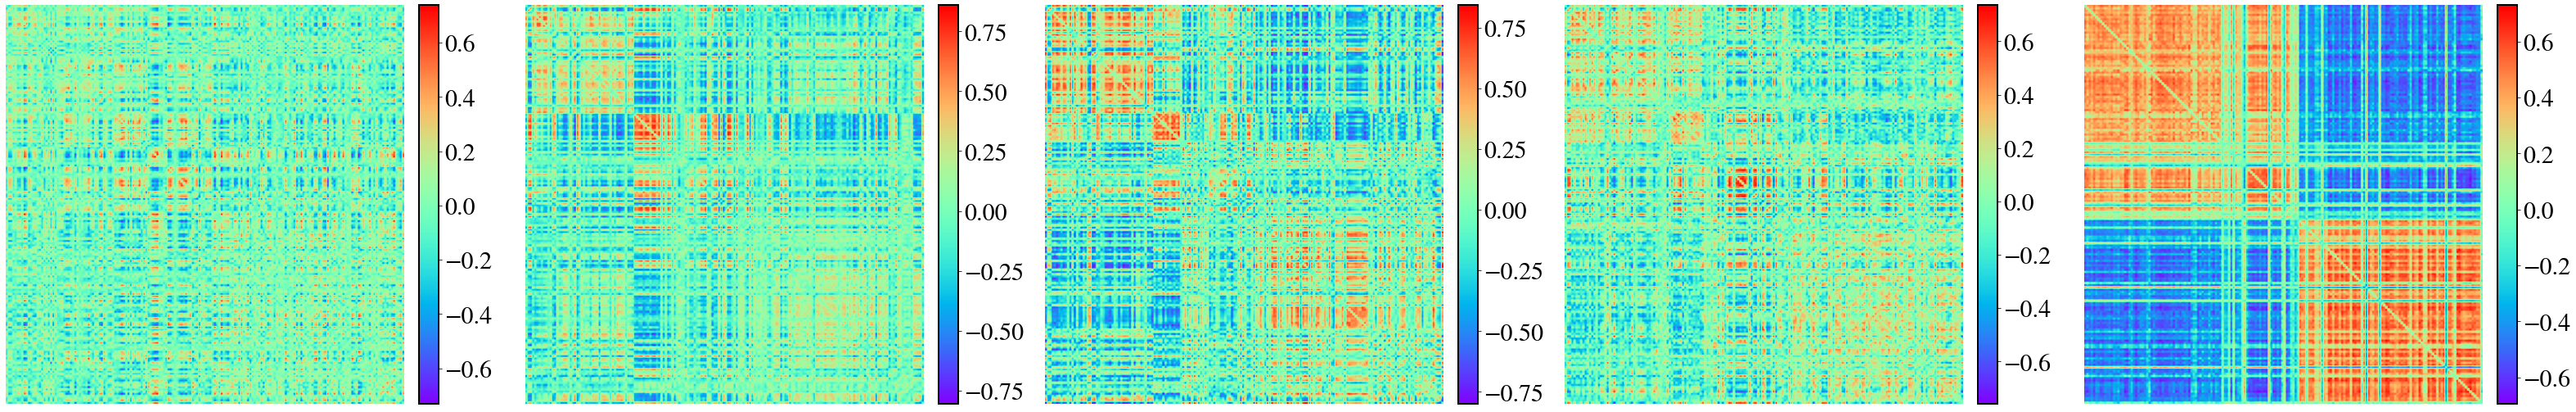

In [5]:
import matplotlib
from scipy.spatial.distance import pdist, squareform

# define plot details
fig, ax = plt.subplots(1, len(roi_sum), figsize=(55, 15))
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

rdm_sum = np.zeros((len(roi_sum), int(180*179/2)))
for idx, check_roi in enumerate(roi_sum):
    mask = eval(f'{check_roi}_mask')
    # specialized voxel loc
    class_pattern = beta_sorted[:, mask]
    # generate rdm
    rdm = np.corrcoef(class_pattern)
    np.fill_diagonal(rdm, 0)
    rdm_triu = rdm[np.triu_indices(rdm.shape[0], k=1)]
    # rdm_triu = pdist(class_pattern, 'correlation')
    # rdm = squareform(rdm_triu)
    rdm_sum[idx] = rdm_triu
    # plot rdm 
    axes = ax[idx]
    im = axes.imshow(rdm, cmap='rainbow', ) #  vmin=0, vmax=1.75
    axes.set_axis_off()
    # axes.set_title(f'{check_roi}', fontsize=25)
    # add colorbar
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.25)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=30)
    # compute corr
    activity_triu = sim_matrix[np.triu_indices(sim_matrix.shape[0], k=1)]
    corr = pearsonr(rdm_triu, activity_triu)[0]
    print('Finish %s %.3f'%(check_roi, corr))
    

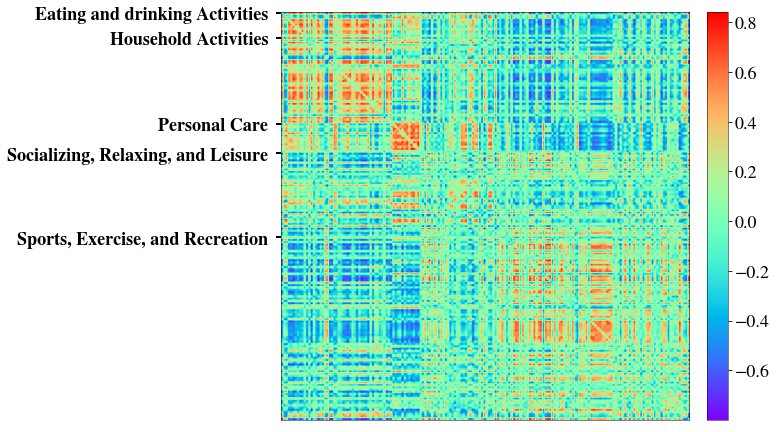

In [11]:
# Show MT RDM with labels annotated 

from scipy.stats import spearmanr
import seaborn as sns

#%% Get super class info used in rdm computation
class_labels = ['Eating and drinking Activities', 'Household Activities', 'Personal Care',
               'Socializing, Relaxing, and Leisure', 'Sports, Exercise, and Recreation']

# show rdm for 1000 class
binsize = np.histogram(superclass_order, 5)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]

# define plot details
fig = plt.figure(figsize=(8, 8))
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# show MT rdm
mask = MT_mask
class_pattern = beta_sorted[:, mask]
rdm = np.corrcoef(class_pattern)
np.fill_diagonal(rdm, 0)
axes = plt.gca()
im_wordnet = axes.imshow(rdm, cmap='rainbow')
axes.set_xticks([])
# axes.set_xticklabels(class_labels, rotation=80, weight='bold')
axes.set_yticks(list(np.array(edges)))
axes.set_yticklabels(class_labels, weight='bold')
axes.tick_params(width=2, length=5, direction="out", pad=8)

# add colorbar
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.25)
fig.colorbar(im_wordnet, cax=cax, orientation='vertical')

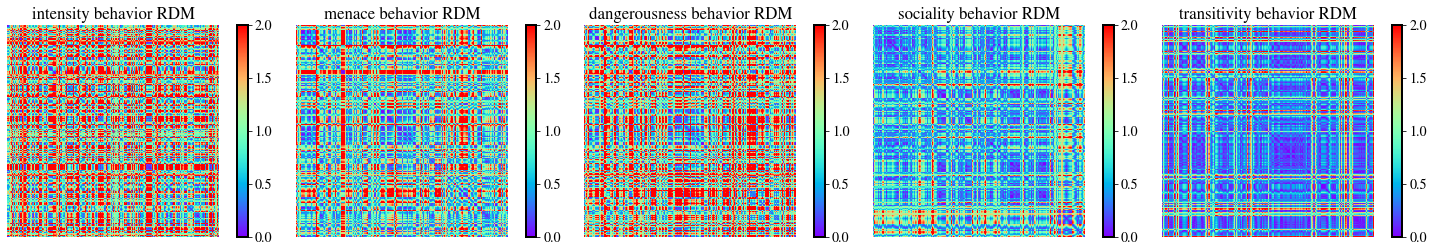

In [20]:
from scipy.stats import spearmanr
import seaborn as sns

def compute_behav_rdm(scr_df):
    mean_scr = scr_df.iloc[:,[1,-1]]
    mean_scr = mean_scr.sort_values(by='class')
    labels = mean_scr.iloc[:,0].to_list()
    scr = mean_scr.iloc[:,1].to_list()
    # compute rdm
    rdm = np.zeros((len(scr), len(scr)))
    for i in np.arange(len(scr)):
        for j in np.arange(len(scr)):
            dis = np.abs(scr[i]-scr[j])
            rdm[i,j] = dis
    return rdm

beh_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/utils/action_spaces/behavior'
dim_fname = pjoin(beh_path, 'dim_scores.csv')
dim_scr_df = pd.read_csv(dim_fname, index_col=0)

actionTax = pd.read_csv(pjoin(beh_path, 'actionTaxonomy.csv'))
actionTax.iloc[82,1] = 'Mopping floor' # 'Mooping floor' --> 'Moppng floor'
actionTax.iloc[90,1] = 'Platform diving' # 'Plataform diving' --> 'Platform diving'
actionTax.iloc[99,1] = 'Playing flauto' # 'Playing flauta' --> 'Playing flauto'
actionTax.iloc[115,1] = 'Polishing furniture' #  'Polishing forniture' --> 'Polishing furniture'

dim_scr_df.insert(0, 'superClass', 0)
for idx, (_, row) in enumerate(dim_scr_df.iterrows()):
    dim_scr_df.iloc[idx,0] = actionTax[actionTax['className']==row['class']]['superClassName'].item()
dim_scr_df = dim_scr_df.sort_values(by='superClass')
dim_scr_df.insert(dim_scr_df.shape[1], 'mean', dim_scr_df.mean(axis=1))
dims = np.delete(dim_scr_df['dim'].unique(), -1)

fig, ax = plt.subplots(1, len(dims), figsize=(25, 6))
rdm_beh_sum = np.zeros((len(dims), int(180*179/2)))
# consider transitivity and sociality dimension only
for dim_idx, dim in enumerate(dims):
    tmp_scr_df = dim_scr_df[dim_scr_df['dim']==dim]
    # compute rdm
    dim_rdm = compute_behav_rdm(tmp_scr_df)
    rdm_beh_sum[dim_idx] = dim_rdm[np.triu_indices(dim_rdm.shape[0], k = 1)]
    # plot rdm
    axes_trans = ax[dim_idx]
    im = axes_trans.imshow(dim_rdm, cmap='rainbow', vmin=0, vmax=2)
    axes_trans.set_title(f'{dim} behavior RDM')
    axes_trans.set_axis_off()
    # add colorbar
    divider = make_axes_locatable(axes_trans)
    cax = divider.append_axes('right', size='5%', pad=0.25)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')


(-0.5, 6.0)

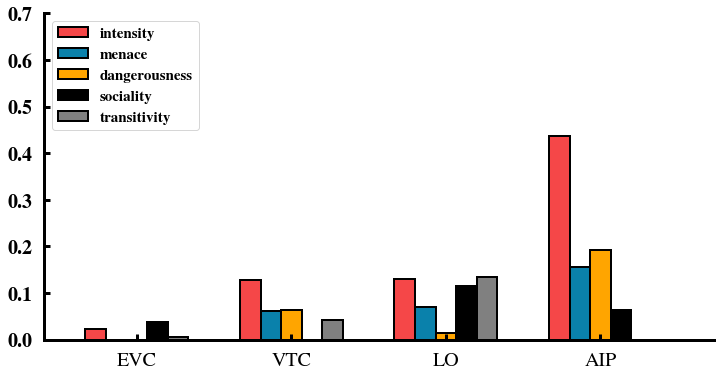

In [16]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

width = 0.2
labels = mask_sum
x_1 = 1.5*np.arange(len(mask_sum))
plt.figure(figsize=(12, 6))
colors = ['#F54748', '#0A81AB', 'orange', 'black', 'grey']

for dim_idx, dim in enumerate(dims):
    corr_dim = [pearsonr(rdm_sum[idx], rdm_beh_sum[dim_idx])[0] for idx in range(rdm_sum.shape[0])]
    plt.bar(x_1+dim_idx*width, corr_dim, color=colors[dim_idx], width=width, label=dim, edgecolor='black', linewidth=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
ax.tick_params(labelsize=20, width=3, length=6, direction="in", pad=12)

plt.xticks(x_1+2*width, labels, weight='bold')
plt.yticks(weight='bold')
plt.legend(loc='upper left', prop={'size':15, 'weight':'bold'})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0))
ax.set_ylim(-0, 0.7)
ax.set_xlim(-0.5, 6)

# for i,t in enumerate(ax.get_xticklabels()):
#     t.set_va('bottom')
#     t.set_rotation_mode('anchor')
#     t.set_position((i,0.05))
